# Проект для «Викишоп» с Bert

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импортируем все необходимые библиотеки и функции

In [ ]:
!pip install -q transformers
!pip install -q optuna

In [1]:
import pandas as pd
import numpy as np
import time


import seaborn as sb 
import matplotlib.pyplot as plt

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer


import torch
import transformers
from tqdm import notebook

import re

from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier


import optuna

import warnings
warnings.filterwarnings('ignore')

import os

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
RANDOM_STATE = 12345

### Загрузим датасет

In [3]:
pth1 = 'toxic_comments.csv'
pth2 = '/datasets/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong') 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


### Удалим столбец Unnamed: 0, т.к. он нам в дальнейшем не понадобится.

In [6]:
df = df.drop('Unnamed: 0', axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Проверим данные на дубликаты

In [7]:
df.duplicated().sum()

0

### Посмотрим на соотношение классов в столбце toxic

In [8]:
df['toxic'].value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

**Вывод** - Загрузили датасет, в котором содержится 159292 комментариев, пропусков и дубликатов в данных нет. Тексты написаны на английском языке. В данных наблюдается явный дисбаланс классов (1 около 10%, 0 около 90%), это нужно учесть при обучении моделей (будем использовать встроенные инструкменты моделей, отвечающие за корректировку дисбаланса классов).

## Обучение (вариант без BERT)

### Будем решать поставленную задачу в следующей последовательности - лемматизация - создание мешка слов или оценка важности слова (TF_IDF) -  обучение модели. 

#### Проведем очистку текста (оставим только буквы алфавита) и лемматизаци комментариев. Для этого сначала напишем функцию очистки и лемматизации текста, потом применим ее ко всему датасету.

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_clean_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower() # удаляем неалфавитные символы, приводим к нижнему регистру
    text = nltk.word_tokenize(text, language = 'english') # токенизируем слова
    text = [lemmatizer.lemmatize(w, pos = 'v') for w in text] # лемматирзируем слова
    return ' '.join(text) # соединяем слова

df['lemm_text'] = df['text'].apply(lemmatize_clean_text)

df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edit make under my usernam...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


#### Разделим наш датасет на обучающую и тестовую выборки в соотношении 75 - 25. Порверим размер.

In [11]:
features = df['lemm_text']
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=RANDOM_STATE, stratify=target)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
target_test.shape


(119469,)
(119469,)
(39823,)


(39823,)

#### Проверим разделение по классам в обучающей и тестовой выборках

In [12]:
target_train.value_counts(normalize=True)

0    0.898384
1    0.101616
Name: toxic, dtype: float64

In [13]:
target_train.value_counts()

0    107329
1     12140
Name: toxic, dtype: int64

In [14]:
target_test.value_counts(normalize=True)

0    0.8984
1    0.1016
Name: toxic, dtype: float64

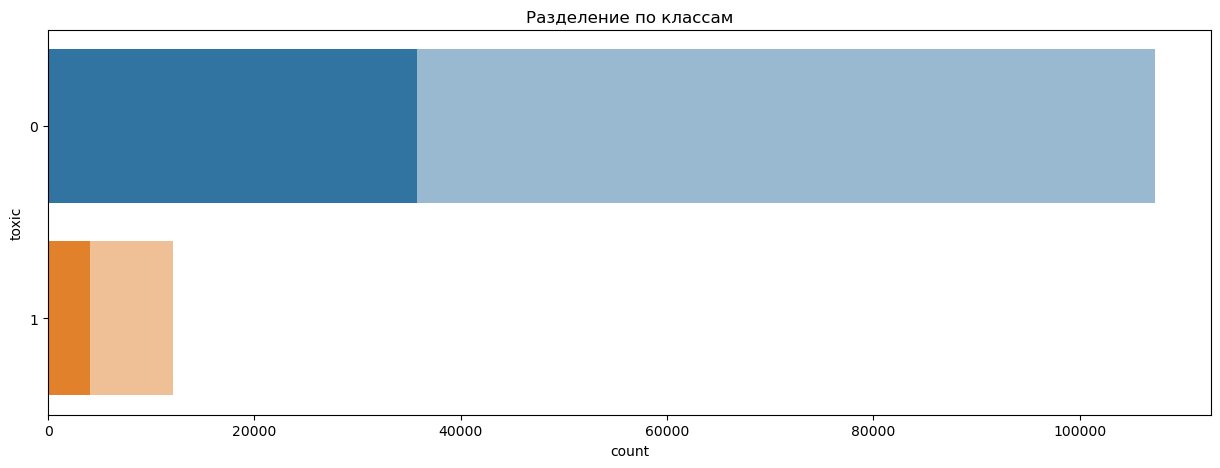

In [15]:
train = pd.DataFrame(target_train, columns=['toxic'])
test = pd.DataFrame(target_test, columns=['toxic'])

fig, ax = plt.subplots(figsize=(15, 5))
sb.countplot(data=train, y='toxic', alpha=.5)
sb.countplot(data=test, y='toxic', alpha=1)
ax.set_title('Разделение по классам')
plt.show()

#### Теперь рассмотрим три модели логистическая регрессия (LogisticRegression), LGBMClassifier, решающее дерево (DecisionTreeClassifier). Для формирования признаков будем использоватьдве  стратегии векторизации: метод создания мешка слов (с помощью метода CountVectorize())  и метода оценки важности слов (с помщью метода TfidfVectorizer()), в обоих случаях избавимся от стоп-слов. Подберем гиперпараметры для модлей. Так как на лицо дисбаланс классов, будем использовать в обоих моделях параметр - class_weight = 'balanced'. Подбор гиперпараметров и стратегии векторизации будем производить с помощью optuna. Метрика качества - F1.

##### Создаем корпус текстов для обучающей и тестовой выборки

In [16]:
corpus_train = features_train.values

In [17]:
corpus_test = features_test.values

##### Загружаем словарь стоп-слов.

In [18]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bniko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##### Выбор модели с помощью optuna

In [19]:
def objective(trial: optuna.Trial):
    vectorizer_type = trial.suggest_categorical("vectorizer_type", ["TfidfVectorizer", "CountVectorizer"])
    
    if vectorizer_type == "TfidfVectorizer":
        vectorizer_type = TfidfVectorizer(stop_words=stopwords, dtype=np.float32)
    elif vectorizer_type == "CountVectorizer":
        vectorizer_type = CountVectorizer(stop_words=stopwords, dtype=np.float32)
    
    model_type = trial.suggest_categorical("model_type", ["Logistic", "Logistic_li", "LGBM", "Tree"])
    
    if model_type == "Logistic":
        lr_params = {
                       
            "C": trial.suggest_float("C", 5, 15),
                       
        }
        
        model = LogisticRegression(**lr_params, solver = 'lbfgs', class_weight = 'balanced', random_state=RANDOM_STATE)
              
    elif model_type == "Logistic_li":
        lrli_params = {
                       
            "C": trial.suggest_float("C", 5, 15),
            "penalty": trial.suggest_categorical("penalty", ['l1', 'l2']),
            
        }
        
        model = LogisticRegression(**lrli_params, solver = 'liblinear', class_weight = 'balanced', random_state=RANDOM_STATE)
                         
    elif model_type == "LGBM":
        lg_params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 100, step=10),
            "num_leaves": trial.suggest_int("num_leaves", 50, 100, step=10),
        }
       
        model = LGBMClassifier(**lg_params, random_seed=RANDOM_STATE, class_weight='balanced')
    
    elif model_type == "Tree":
        t_params = {
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 3),
            "max_depth": trial.suggest_int("max_depth", 1, 10, step=10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
        }
       
    
        model = DecisionTreeClassifier(**t_params, random_state=RANDOM_STATE, class_weight='balanced')  
    
      
    
    pipe = Pipeline(steps=[
        ("vectorizer_type",  vectorizer_type),
        ("model", model)
    ])
    
    cv = 3
    score = cross_val_score(estimator=pipe,
                            X=corpus_train,
                            y=target_train,
                            scoring='f1',
                            cv=cv)
    
    trial.set_user_attr("model", pipe)
    trial.set_user_attr("cross_val_score", score)
    
    f1 = score.mean()
    return f1  

In [20]:
# функция для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

In [21]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[custom_callback])

[I 2024-01-24 08:41:19,929] A new study created in memory with name: no-name-909e409e-8626-4fea-b6d7-16a1b5649cf5
[I 2024-01-24 08:42:09,520] Trial 0 finished with value: 0.74668144686657 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'Logistic_li', 'C': 6, 'penalty': 'l2'}. Best is trial 0 with value: 0.74668144686657.


Trial 0: cross_val_score=[0.75213291 0.74418605 0.74372538]


[I 2024-01-24 08:42:28,452] Trial 1 finished with value: 0.37752338795437784 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.74668144686657.


Trial 1: cross_val_score=[0.3797619  0.384661   0.36814726]


[I 2024-01-24 08:42:47,919] Trial 2 finished with value: 0.37752338795437784 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.74668144686657.


Trial 2: cross_val_score=[0.3797619  0.384661   0.36814726]
[LightGBM] [Info] Number of positive: 8094, number of negative: 71552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.133039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33392
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.149169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33526
[LightGBM] [Info] Number of data points in the trai

[I 2024-01-24 08:43:24,463] Trial 3 finished with value: 0.7208412564066261 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 90}. Best is trial 0 with value: 0.74668144686657.


Trial 3: cross_val_score=[0.72066298 0.7229153  0.71894549]


[I 2024-01-24 08:43:51,024] Trial 4 finished with value: 0.7534012192737922 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'Logistic', 'C': 6}. Best is trial 4 with value: 0.7534012192737922.


Trial 4: cross_val_score=[0.75659347 0.75694038 0.74666981]
[LightGBM] [Info] Number of positive: 8094, number of negative: 71552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.127076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390890
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.137058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 391299
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7610
[LightGBM] [Info] 

[I 2024-01-24 08:45:24,631] Trial 5 finished with value: 0.740447286891378 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'LGBM', 'n_estimators': 90, 'num_leaves': 90}. Best is trial 4 with value: 0.7534012192737922.


Trial 5: cross_val_score=[0.73719752 0.74280616 0.74133818]


[I 2024-01-24 08:45:47,956] Trial 6 finished with value: 0.7603620810567979 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 5, 'penalty': 'l2'}. Best is trial 6 with value: 0.7603620810567979.


Trial 6: cross_val_score=[0.75744199 0.76194801 0.76169624]
[LightGBM] [Info] Number of positive: 8094, number of negative: 71552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.083770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33392
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.161806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33526
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7610
[LightGBM] [Info] [b

[I 2024-01-24 08:46:26,385] Trial 7 finished with value: 0.7270439965323002 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 90}. Best is trial 6 with value: 0.7603620810567979.


Trial 7: cross_val_score=[0.72836218 0.72798691 0.7247829 ]


[I 2024-01-24 08:46:50,647] Trial 8 finished with value: 0.7629958614109368 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 9, 'penalty': 'l2'}. Best is trial 8 with value: 0.7629958614109368.


Trial 8: cross_val_score=[0.7616092  0.76507277 0.76230562]


[I 2024-01-24 08:47:09,911] Trial 9 finished with value: 0.37752338795437784 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 3}. Best is trial 8 with value: 0.7629958614109368.


Trial 9: cross_val_score=[0.3797619  0.384661   0.36814726]


[I 2024-01-24 08:47:46,513] Trial 10 finished with value: 0.7510052806080457 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 13, 'penalty': 'l1'}. Best is trial 8 with value: 0.7629958614109368.


Trial 10: cross_val_score=[0.74926393 0.75556614 0.74818578]


[I 2024-01-24 08:48:10,460] Trial 11 finished with value: 0.7626178331132661 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 10, 'penalty': 'l2'}. Best is trial 8 with value: 0.7629958614109368.


Trial 11: cross_val_score=[0.76167416 0.7642634  0.76191594]


[I 2024-01-24 08:48:34,368] Trial 12 finished with value: 0.7626178331132661 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 10, 'penalty': 'l2'}. Best is trial 8 with value: 0.7629958614109368.


Trial 12: cross_val_score=[0.76167416 0.7642634  0.76191594]


[I 2024-01-24 08:48:58,639] Trial 13 finished with value: 0.7626178331132661 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 10, 'penalty': 'l2'}. Best is trial 8 with value: 0.7629958614109368.


Trial 13: cross_val_score=[0.76167416 0.7642634  0.76191594]


[I 2024-01-24 08:49:26,522] Trial 14 finished with value: 0.762854856025395 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 9}. Best is trial 8 with value: 0.7629958614109368.


Trial 14: cross_val_score=[0.76111686 0.76473982 0.76270789]


[I 2024-01-24 08:49:53,389] Trial 15 finished with value: 0.7625788417775518 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 8}. Best is trial 8 with value: 0.7629958614109368.


Trial 15: cross_val_score=[0.76119574 0.76431364 0.76222715]


[I 2024-01-24 08:50:21,786] Trial 16 finished with value: 0.7623294937638226 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 13}. Best is trial 8 with value: 0.7629958614109368.


Trial 16: cross_val_score=[0.76271186 0.7646306  0.75964602]


[I 2024-01-24 08:50:49,067] Trial 17 finished with value: 0.7625788417775518 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 8}. Best is trial 8 with value: 0.7629958614109368.


Trial 17: cross_val_score=[0.76119574 0.76431364 0.76222715]


[I 2024-01-24 08:51:16,345] Trial 18 finished with value: 0.7629007893191848 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 15}. Best is trial 8 with value: 0.7629958614109368.


Trial 18: cross_val_score=[0.76293706 0.7664489  0.7593164 ]


[I 2024-01-24 08:51:44,198] Trial 19 finished with value: 0.7629007893191848 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 15}. Best is trial 8 with value: 0.7629958614109368.


Trial 19: cross_val_score=[0.76293706 0.7664489  0.7593164 ]


[I 2024-01-24 08:52:12,811] Trial 20 finished with value: 0.7520765320186141 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 12, 'penalty': 'l1'}. Best is trial 8 with value: 0.7629958614109368.


Trial 20: cross_val_score=[0.75141243 0.75671819 0.74809897]


[I 2024-01-24 08:52:40,276] Trial 21 finished with value: 0.7629007893191848 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 15}. Best is trial 8 with value: 0.7629958614109368.


Trial 21: cross_val_score=[0.76293706 0.7664489  0.7593164 ]


[I 2024-01-24 08:53:07,778] Trial 22 finished with value: 0.7629007893191848 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 15}. Best is trial 8 with value: 0.7629958614109368.


Trial 22: cross_val_score=[0.76293706 0.7664489  0.7593164 ]


[I 2024-01-24 08:53:35,580] Trial 23 finished with value: 0.7624173907479618 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 14}. Best is trial 8 with value: 0.7629958614109368.


Trial 23: cross_val_score=[0.76246948 0.76519916 0.75958353]


[I 2024-01-24 08:54:03,292] Trial 24 finished with value: 0.7626780515067605 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 12}. Best is trial 8 with value: 0.7629958614109368.


Trial 24: cross_val_score=[0.76271186 0.76469906 0.76062323]


[I 2024-01-24 08:54:30,434] Trial 25 finished with value: 0.7626780515067605 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 12}. Best is trial 8 with value: 0.7629958614109368.


Trial 25: cross_val_score=[0.76271186 0.76469906 0.76062323]


[I 2024-01-24 08:54:50,920] Trial 26 finished with value: 0.37752338795437784 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 8 with value: 0.7629958614109368.


Trial 26: cross_val_score=[0.3797619  0.384661   0.36814726]
[LightGBM] [Info] Number of positive: 8094, number of negative: 71552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.147162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 390890
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 8093, number of negative: 71553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.112861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 391299
[LightGBM] [Info] Number of data points in the train set: 79646, number of used features: 7610
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[L

[I 2024-01-24 08:56:03,488] Trial 27 finished with value: 0.7357114520986127 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'LGBM', 'n_estimators': 100, 'num_leaves': 50}. Best is trial 8 with value: 0.7629958614109368.


Trial 27: cross_val_score=[0.7345113  0.73716678 0.73545628]


[I 2024-01-24 08:56:31,453] Trial 28 finished with value: 0.7624173907479618 and parameters: {'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic', 'C': 14}. Best is trial 8 with value: 0.7629958614109368.


Trial 28: cross_val_score=[0.76246948 0.76519916 0.75958353]


[I 2024-01-24 10:09:45,383] Trial 29 finished with value: 0.6278284511642241 and parameters: {'vectorizer_type': 'CountVectorizer', 'model_type': 'Logistic_li', 'C': 11, 'penalty': 'l1'}. Best is trial 8 with value: 0.7629958614109368.


Trial 29: cross_val_score=[0.63122148 0.63105175 0.62121212]


##### Вывод лучших параметров 

In [22]:
study.best_params

{'vectorizer_type': 'TfidfVectorizer',
 'model_type': 'Logistic_li',
 'C': 9,
 'penalty': 'l2'}

##### Вывод лучшего триала

In [23]:
study.best_trial

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.7629958614109368], datetime_start=datetime.datetime(2024, 1, 24, 8, 46, 26, 386889), datetime_complete=datetime.datetime(2024, 1, 24, 8, 46, 50, 646613), params={'vectorizer_type': 'TfidfVectorizer', 'model_type': 'Logistic_li', 'C': 9, 'penalty': 'l2'}, user_attrs={'model': Pipeline(steps=[('vectorizer_type',
                 TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                             

##### Вывод значения метрики лучшей модели на обучающей выборке

In [24]:
study.best_value

0.7629958614109368

##### Сохраняем модель с лучшими параметрами

In [25]:
best_model = study.best_trial.user_attrs['model']
best_model

Pipeline(steps=[('vectorizer_type',
                 TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LogisticRegression(C=9, class_weight='balanced',
                                    random_state=12345, solver='liblinear'))])

In [26]:
best_model.fit(corpus_train, target_train)

Pipeline(steps=[('vectorizer_type',
                 TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('model',
                 LogisticRegression(C=9, class_weight='balanced',
                                    random_state=12345, solver='liblinear'))])

**Вывод** Получили, что лучший показатель метрики качества F1 наблюдается у модели LogisticRegression. , где векторизация производилась с помощью метода TfidfVectorizer. Протестируем полученную модель на тестовой выборке.

## Выводы

### Протестируем модель, показавшую самый хороший результат, на тестовой выборке, а также посчитаем ROC-AUC.

In [27]:
%%time
start_time = time.time()
predictions_test = best_model.predict(corpus_test)
prediction_proba_test = best_model.predict_proba(corpus_test)[:, 1]
end_time = time.time()
pred_time = end_time - start_time
print('F1', f1_score(target_test, predictions_test).round(3))
print('roc_au', roc_auc_score(target_test, prediction_proba_test).round(3))
print(pred_time)

F1 0.768
roc_au 0.969
4.268668174743652
Wall time: 4.3 s


**Вывод**: Метрика F1, полученная на тестовой выборке, также соответсвует условию задачи. Скорость предсказания модели достаточно хорошая.

### **Итоговые выводы** 

В ходе решения задачи было сделано следующее:

1. Загрузили данныне. В  датасете содержится 159292 комментария, пропусков и дубликатов в данных нет. Тексты написаны на английском языке. В данных наблюдается явный дисбаланс классов (1 около 10%, 0 около 90%), что в дальнейшем учитывалось при обучении моделей.

2. Провели очистку текста(оставили только буквы алфавита) и лемматизацию комментариев.

3. Подобрали гиперпараметры и обучили 3 модели - LogisticRegression, LGBMClassifier, DecisionTreeClassifier с двумя стратегиями векторизации "создание мешка слов" и метода оценки важности слов. Лучше моделью оказалась LogisticRegression, где векторизация производилась с помощью метода TfidfVectorizer. F1 > 0.75 соответсвует условию задачи.

4. Оценили метрику качества F-1 LogisticRegression на тестовой выборке, она также > 0.75, что соответсвует условиям поставленной задачи. 

## Вариант решения с предобученной моделью BERT

Делала данный вариант на части датасета (нет возможности делать расчеты на gpu), чтобы просто отработать саму схему. Брала две предобученных модели BERT. Спачала bert-base-uncased, не получив на ней хороших результатов, рассмотрела модель - toxic-bert.

### Делаем случайную выборку из 1000 твитов, чтобы сократить время на получение эмбеддингов.

In [28]:
df_bert = df.sample(1000).reset_index(drop=True)
print(df_bert.shape)
df_bert.head()

(1000, 3)


,text,toxic,lemm_text
0,You do not know that we have two different cat...,0,you do not know that we have two different cat...
1,"""\n The post on my talk page and at WT:PW \n\n...",0,the post on my talk page and at wt pw again so...
2,You would \n\nyou know you would.\n\nhands off!,0,you would you know you would hand off
3,My apologies for calling you Graham! sorry abo...,0,my apologies for call you graham sorry about t...
4,I have seen no spamming or hoaxing on this art...,0,i have see no spamming or hoax on this article...


### Проверяем солотношение классов.

In [29]:
df_bert['toxic'].value_counts(normalize=True)

0    0.911
1    0.089
Name: toxic, dtype: float64

### Модель bert-base-uncased

#### Загружаем модель bert-base-uncased и токенизатор для нее.

In [30]:
model = transformers.BertModel.from_pretrained('bert-base-uncased')
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, truncation=True))

max_len = max([len(i) for i in tokenized.values])
print(max_len)
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

512


### Получаем эмбеддинги с помощью модели bert-base-uncased, загружая в нее данные по частям.

In [31]:
batch_size = 100
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/10 [00:00<?, ?it/s]

#### Получаем признаки для обучения и тестирования моделей.

In [32]:
features_base = np.concatenate(embeddings)
features_base.shape

(1000, 768)

#### Разделяем данные на выборки: обучающую и тестовую.

In [33]:
train_base, test_base, tb_train, td_test = train_test_split(features_base, df_bert['toxic'], random_state=RANDOM_STATE, stratify=df_bert['toxic'])


#### С помощью optuna подираем модель (берем теже, что в обучении без BERT) и гиперпараметры

In [34]:
def objective(trial: optuna.Trial):
       
    model_type = trial.suggest_categorical("model_type", ["Logistic", "LGBM", "Tree"])
    
    if model_type == "Logistic":
        lr_params = {
                       
            "solver": trial.suggest_categorical("solver", ['lbfgs', 'liblinear']),
            "C": trial.suggest_float("C", 1, 11),
            
        }
        
        model = LogisticRegression(**lr_params, class_weight = 'balanced', random_state=RANDOM_STATE)
              
               
    elif model_type == "LGBM":
        lg_params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 100, step=10),
            "num_leaves": trial.suggest_int("num_leaves", 50, 100, step=10),
        }
       
        model = LGBMClassifier(**lg_params, random_seed=RANDOM_STATE, class_weight='balanced')
    
    elif model_type == "Tree":
        t_params = {
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 3),
            "max_depth": trial.suggest_int("max_depth", 1, 10, step=10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
        }
       
    
        model = DecisionTreeClassifier(**t_params, random_state=RANDOM_STATE, class_weight='balanced')  
    
      
        
    cv = 5
    score = cross_val_score(estimator=model,
                            X=train_base,
                            y=tb_train,
                            scoring='f1',
                            cv=cv)
    
    trial.set_user_attr("model", model)
    trial.set_user_attr("cross_val_score", score)
    
    f1 = score.mean()
    return f1  

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[custom_callback])

[I 2024-01-23 15:56:25,825] A new study created in memory with name: no-name-758a1b62-197d-4a71-9630-29855639209e


[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153933
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-01-23 15:56:34,351] Trial 0 finished with value: 0.33333333333333337 and parameters: {'model_type': 'LGBM', 'n_estimators': 100, 'num_leaves': 90}. Best is trial 0 with value: 0.33333333333333337.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-01-23 15:56:34,559] Trial 1 finished with value: 0.33956964604023426 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.33956964604023426.


Trial 0: cross_val_score=[0.33333333 0.26666667 0.33333333 0.33333333 0.4       ]
Trial 1: cross_val_score=[0.23529412 0.5        0.24242424 0.32727273 0.39285714]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153933
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[I 2024-01-23 15:56:39,025] Trial 2 finished with value: 0.40200373055400646 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 100}. Best is trial 2 with value: 0.40200373055400646.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 2: cross_val_score=[0.42105263 0.35294118 0.33333333 0.38095238 0.52173913]


[I 2024-01-23 15:56:39,228] Trial 3 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 9.041482648951158}. Best is trial 3 with value: 0.5061996779388084.


Trial 3: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153933
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 15:56:44,281] Trial 4 finished with value: 0.3681639928698753 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 50}. Best is trial 3 with value: 0.5061996779388084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 4: cross_val_score=[0.4        0.35294118 0.33333333 0.3        0.45454545]


[I 2024-01-23 15:56:44,485] Trial 5 finished with value: 0.33956964604023426 and parameters: {'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.5061996779388084.


Trial 5: cross_val_score=[0.23529412 0.5        0.24242424 0.32727273 0.39285714]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153933
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 15:56:48,632] Trial 6 finished with value: 0.40200373055400646 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 100}. Best is trial 3 with value: 0.5061996779388084.


Trial 6: cross_val_score=[0.42105263 0.35294118 0.33333333 0.38095238 0.52173913]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153933
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 15:56:53,552] Trial 7 finished with value: 0.3681639928698753 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 50}. Best is trial 3 with value: 0.5061996779388084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 7: cross_val_score=[0.4        0.35294118 0.33333333 0.3        0.45454545]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choo

[I 2024-01-23 15:57:02,027] Trial 8 finished with value: 0.33333333333333337 and parameters: {'model_type': 'LGBM', 'n_estimators': 100, 'num_leaves': 60}. Best is trial 3 with value: 0.5061996779388084.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 8: cross_val_score=[0.33333333 0.26666667 0.33333333 0.33333333 0.4       ]


[I 2024-01-23 15:57:02,779] Trial 9 finished with value: 0.5201871591676689 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.6172879138906406}. Best is trial 9 with value: 0.5201871591676689.


Trial 9: cross_val_score=[0.52173913 0.64285714 0.38461538 0.55172414 0.5       ]


[I 2024-01-23 15:57:03,534] Trial 10 finished with value: 0.5101342491147588 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.6396904529687344}. Best is trial 9 with value: 0.5201871591676689.


Trial 10: cross_val_score=[0.52173913 0.59259259 0.38461538 0.55172414 0.5       ]


[I 2024-01-23 15:57:04,224] Trial 11 finished with value: 0.5177506631299734 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.1642652921063241}. Best is trial 9 with value: 0.5201871591676689.


Trial 11: cross_val_score=[0.48       0.62068966 0.38461538 0.55172414 0.55172414]


[I 2024-01-23 15:57:04,837] Trial 12 finished with value: 0.5158393330807123 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.335154704167015}. Best is trial 9 with value: 0.5201871591676689.


Trial 12: cross_val_score=[0.5        0.64285714 0.38461538 0.55172414 0.5       ]


[I 2024-01-23 15:57:05,747] Trial 13 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 3.9589417135712646}. Best is trial 9 with value: 0.5201871591676689.


Trial 13: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:06,630] Trial 14 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 4.709803163755209}. Best is trial 9 with value: 0.5201871591676689.


Trial 14: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:07,422] Trial 15 finished with value: 0.5132111721916819 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.8206674793865465}. Best is trial 9 with value: 0.5201871591676689.
[I 2024-01-23 15:57:07,617] Trial 16 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 8.098724212030247}. Best is trial 9 with value: 0.5201871591676689.


Trial 15: cross_val_score=[0.52173913 0.59259259 0.4        0.55172414 0.5       ]
Trial 16: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:08,473] Trial 17 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 3.6369429199115437}. Best is trial 9 with value: 0.5201871591676689.
[I 2024-01-23 15:57:08,690] Trial 18 finished with value: 0.33956964604023426 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.5201871591676689.


Trial 17: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]
Trial 18: cross_val_score=[0.23529412 0.5        0.24242424 0.32727273 0.39285714]


[I 2024-01-23 15:57:09,540] Trial 19 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 6.826307229424082}. Best is trial 9 with value: 0.5201871591676689.
[I 2024-01-23 15:57:09,731] Trial 20 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 2.942458228621642}. Best is trial 9 with value: 0.5201871591676689.


Trial 19: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]
Trial 20: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:10,423] Trial 21 finished with value: 0.5149016602809706 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.101484079021894}. Best is trial 9 with value: 0.5201871591676689.


Trial 21: cross_val_score=[0.48       0.62068966 0.37037037 0.55172414 0.55172414]


[I 2024-01-23 15:57:11,206] Trial 22 finished with value: 0.5149016602809706 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 1.0417019899821272}. Best is trial 9 with value: 0.5201871591676689.


Trial 22: cross_val_score=[0.48       0.62068966 0.37037037 0.55172414 0.55172414]


[I 2024-01-23 15:57:11,889] Trial 23 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 2.4131700343625684}. Best is trial 9 with value: 0.5201871591676689.


Trial 23: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:12,729] Trial 24 finished with value: 0.49074074074074076 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 10.739999613277666}. Best is trial 9 with value: 0.5201871591676689.


Trial 24: cross_val_score=[0.5        0.59259259 0.41666667 0.5        0.44444444]


[I 2024-01-23 15:57:12,960] Trial 25 finished with value: 0.33956964604023426 and parameters: {'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 9 with value: 0.5201871591676689.


Trial 25: cross_val_score=[0.23529412 0.5        0.24242424 0.32727273 0.39285714]


[I 2024-01-23 15:57:13,752] Trial 26 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 5.40798615530128}. Best is trial 9 with value: 0.5201871591676689.


Trial 26: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:14,500] Trial 27 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 2.7375470314179235}. Best is trial 9 with value: 0.5201871591676689.


Trial 27: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:14,699] Trial 28 finished with value: 0.5061996779388084 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 3.4330567425175467}. Best is trial 9 with value: 0.5201871591676689.


Trial 28: cross_val_score=[0.52173913 0.59259259 0.41666667 0.5        0.5       ]


[I 2024-01-23 15:57:14,939] Trial 29 finished with value: 0.33956964604023426 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 9 with value: 0.5201871591676689.


Trial 29: cross_val_score=[0.23529412 0.5        0.24242424 0.32727273 0.39285714]


In [36]:
study.best_value

0.5201871591676689

**Вывод:** Полученные результаты не соответсвует заданному уровню качества. На тестовой выборке проверять не будем.

### Модель toxic-bert

#### Загружаем молдель и токенизатор, создаемм эмбеддинги.

In [38]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')

# Токенизация списка твитов
encoded_tweets = tokenizer.batch_encode_plus(
    np.ascontiguousarray(df_bert['text']),
    add_special_tokens=True, # Добавление специальных токенов начала и разделитель к входным данным перед кодированием
    padding=True, # Добавление заполнения до одинаковой длины
    truncation=True, # Обрезка последовательностей, если они превышают максимальную длину
    max_length=512, # Установка максимальной длины токена
    return_tensors='pt' # Возврат тензоров PyTorch
)
print(encoded_tweets['input_ids'].shape, encoded_tweets['attention_mask'].shape)

batch_size = 100
embeddings = []
for i in notebook.tqdm(range(encoded_tweets['input_ids'].shape[0] // batch_size)):
    batch = torch.LongTensor(encoded_tweets['input_ids'][batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(encoded_tweets['attention_mask'][batch_size*i:batch_size*(i+1)]) 
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())        


torch.Size([1000, 512]) torch.Size([1000, 512])


  0%|          | 0/10 [00:00<?, ?it/s]

#### Создаем признаки для обучения моделей и делим данные на обучающую и тестовую выборки

In [39]:
features_toxic = np.concatenate(embeddings)
features_toxic.shape

(1000, 768)

In [40]:
train, test, t_train, t_test = train_test_split(features_toxic, df_bert['toxic'], random_state=RANDOM_STATE, stratify=df_bert['toxic'])

print(train.shape)
print(t_train.shape)
print(test.shape)
t_test.shape


(750, 768)
(750,)
(250, 768)


(250,)

#### Прорверяем баланс классов

In [41]:
print(t_train.value_counts(normalize=True))
t_test.value_counts(normalize=True)

0    0.910667
1    0.089333
Name: toxic, dtype: float64


0    0.912
1    0.088
Name: toxic, dtype: float64

#### С помощью optuna выбираем модель (берем теже модели) и гиперпараметры.

In [42]:
def objective(trial: optuna.Trial):
       
    model_type = trial.suggest_categorical("model_type", ["Logistic", "LGBM", "Tree"])
    
    if model_type == "Logistic":
        lr_params = {
                       
            "solver": trial.suggest_categorical("solver", ['lbfgs', 'liblinear']),
            "C": trial.suggest_float("C", 1, 11),
            
        }
        
        model = LogisticRegression(**lr_params, class_weight = 'balanced', random_state=RANDOM_STATE)
              
               
    elif model_type == "LGBM":
        lg_params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 100, step=10),
            "num_leaves": trial.suggest_int("num_leaves", 50, 100, step=10),
        }
       
        model = LGBMClassifier(**lg_params, random_seed=RANDOM_STATE, class_weight='balanced')
    
    elif model_type == "Tree":
        t_params = {
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 3),
            "max_depth": trial.suggest_int("max_depth", 1, 10, step=10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 5),
        }
       
    
        model = DecisionTreeClassifier(**t_params, random_state=RANDOM_STATE, class_weight='balanced')  
    
      
        
    cv = 5
    score = cross_val_score(estimator=model,
                            X=train,
                            y=t_train,
                            scoring='f1',
                            cv=cv)
    
    trial.set_user_attr("model", model)
    trial.set_user_attr("cross_val_score", score)
    
    f1 = score.mean()
    return f1  

In [43]:
# функция для вывода метрик
def custom_callback(study: optuna.Study, trial: optuna.Trial):
    trial.user_attrs["cross_val_score"]
    score = trial.user_attrs["cross_val_score"]
    print(f"Trial {trial.number}: cross_val_score={score}")

In [44]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, callbacks=[custom_callback])

[I 2024-01-23 16:17:13,416] A new study created in memory with name: no-name-df8372c4-ff40-45fa-87ce-29e04df5db1a


[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2024-01-23 16:17:17,969] Trial 0 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


Trial 0: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]


[I 2024-01-23 16:17:18,205] Trial 1 finished with value: 0.9044685990338165 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 8.664855035913085}. Best is trial 0 with value: 0.9082698412698413.


Trial 1: cross_val_score=[0.86956522 1.         0.88888889 0.88888889 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 16:17:24,699] Trial 2 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 70, 'num_leaves': 80}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 2: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]


[I 2024-01-23 16:17:25,327] Trial 3 finished with value: 0.9060559006211181 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 4.5429630735316024}. Best is trial 0 with value: 0.9082698412698413.


Trial 3: cross_val_score=[0.86956522 1.         0.85714286 0.92857143 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 16:17:34,262] Trial 4 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 100, 'num_leaves': 80}. Best is trial 0 with value: 0.9082698412698413.
[I 2024-01-23 16:17:34,450] Trial 5 finished with value: 0.9065302666127254 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 4.150876400985294}. Best is trial 0 with value: 0.9082698412698413.


Trial 4: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]
Trial 5: cross_val_score=[0.86956522 0.96296296 0.89655172 0.92857143 0.875     ]


[I 2024-01-23 16:17:35,210] Trial 6 finished with value: 0.8981193926846102 and parameters: {'model_type': 'Logistic', 'solver': 'liblinear', 'C': 6.8016838719490185}. Best is trial 0 with value: 0.9082698412698413.


Trial 6: cross_val_score=[0.86956522 1.         0.85714286 0.88888889 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 16:17:40,024] Trial 7 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 7: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]


[I 2024-01-23 16:17:40,290] Trial 8 finished with value: 0.8266888922061335 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9082698412698413.


Trial 8: cross_val_score=[0.78571429 0.78787879 0.89655172 0.81481481 0.84848485]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2024-01-23 16:17:47,432] Trial 9 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 80, 'num_leaves': 50}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 9: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]


[I 2024-01-23 16:17:47,645] Trial 10 finished with value: 0.8266888922061335 and parameters: {'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9082698412698413.


Trial 10: cross_val_score=[0.78571429 0.78787879 0.89655172 0.81481481 0.84848485]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007550 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:17:52,313] Trial 11 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 11: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:17:56,938] Trial 12 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 100}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 12: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:02,661] Trial 13 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 13: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:07,335] Trial 14 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 14: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007721 second

[I 2024-01-23 16:18:13,651] Trial 15 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 70, 'num_leaves': 90}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 15: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]


[I 2024-01-23 16:18:13,881] Trial 16 finished with value: 0.8266888922061335 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9082698412698413.


Trial 16: cross_val_score=[0.78571429 0.78787879 0.89655172 0.81481481 0.84848485]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:19,213] Trial 17 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 17: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train 

[I 2024-01-23 16:18:26,890] Trial 18 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 90, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 18: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]


[I 2024-01-23 16:18:27,106] Trial 19 finished with value: 0.8266888922061335 and parameters: {'model_type': 'Tree', 'min_samples_split': 3, 'max_depth': 1, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9082698412698413.


Trial 19: cross_val_score=[0.78571429 0.78787879 0.89655172 0.81481481 0.84848485]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:32,383] Trial 20 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 20: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:36,787] Trial 21 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 21: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

[I 2024-01-23 16:18:41,110] Trial 22 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 50}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 22: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start trainin

[I 2024-01-23 16:18:46,305] Trial 23 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 23: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:18:50,639] Trial 24 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 80}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 24: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start trainin

[I 2024-01-23 16:18:56,029] Trial 25 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 60, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 25: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:19:00,418] Trial 26 finished with value: 0.9082698412698413 and parameters: {'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 60}. Best is trial 0 with value: 0.9082698412698413.


Trial 26: cross_val_score=[0.96       0.96296296 0.92857143 0.81481481 0.875     ]
[LightGBM] [Info] Number of positive: 54, number of negative: 546
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154101
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-01-23 16:19:06,504] Trial 27 finished with value: 0.9066011396011397 and parameters: {'model_type': 'LGBM', 'n_estimators': 70, 'num_leaves': 70}. Best is trial 0 with value: 0.9082698412698413.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Trial 27: cross_val_score=[0.96       0.96296296 0.88888889 0.84615385 0.875     ]


[I 2024-01-23 16:19:06,716] Trial 28 finished with value: 0.8266888922061335 and parameters: {'model_type': 'Tree', 'min_samples_split': 2, 'max_depth': 1, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9082698412698413.
[I 2024-01-23 16:19:06,886] Trial 29 finished with value: 0.9012272363096951 and parameters: {'model_type': 'Logistic', 'solver': 'lbfgs', 'C': 1.7208298742553518}. Best is trial 0 with value: 0.9082698412698413.


Trial 28: cross_val_score=[0.78571429 0.78787879 0.89655172 0.81481481 0.84848485]
Trial 29: cross_val_score=[0.86956522 0.96296296 0.89655172 0.92857143 0.84848485]


In [45]:
study.best_params

{'model_type': 'LGBM', 'n_estimators': 50, 'num_leaves': 70}

In [46]:
study.best_value

0.9082698412698413

In [47]:
best_model_bert = study.best_trial.user_attrs['model']
best_model_bert

LGBMClassifier(class_weight='balanced', n_estimators=50, num_leaves=70,
               random_seed=12345)

In [48]:
best_model_bert.fit(train, t_train)

[LightGBM] [Info] Number of positive: 67, number of negative: 683
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 192324
[LightGBM] [Info] Number of data points in the train set: 750, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(class_weight='balanced', n_estimators=50, num_leaves=70,
               random_seed=12345)

**Вывод** - Получили, что значение метрики f1 на  лучшей модели больше 0.75, что соответсвует требованиям задания. И значение метрики значительно лучше, чем в решении задачи без BERT. Но в данном случае задача решена только на маленькой части датасета.

### Проведем тестирование модели на тестовой выборке.

In [49]:
%%time
start_time_bert = time.time()
predictions_test_bert = best_model_bert.predict(test)
prediction_proba_test_bert= best_model_bert.predict_proba(test)[:, 1]
end_time_bert= time.time()
pred_time_bert = end_time_bert - start_time_bert
print('F1', f1_score(t_test, predictions_test_bert).round(3))
print('roc_au', roc_auc_score(t_test, prediction_proba_test_bert).round(3))
print(pred_time_bert)

F1 0.977
roc_au 0.999
0.004996061325073242
Wall time: 9.28 ms


**Вывод:** Метрика F1, полученная на тестовой выборке, также соответсвует условию задачи. Скорость предсказания модели достаточно хорошая. 
Вариант решения задачи с BERT дает лучшие результьаты, но требует много временных ресурсов для получения эмбеддингов на всем датасете.